In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
TEST_DIR = 'C:/Users/HP/Downloads/test'
TRAIN_DIR ='C:/Users/HP/Downloads/test'
VALID_DIR ='C:/Users/HP/Downloads/test'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                               seed=2509,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 359 files belonging to 36 classes.


In [26]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(VALID_DIR,
                                                               seed=2509,
                                                               image_size=(img_height, img_width),
                                                               shuffle=False,
                                                               batch_size=batch_size)

Found 359 files belonging to 36 classes.


In [27]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                              seed=2509,
                                                              image_size=(img_height, img_width),
                                                              shuffle=False,
                                                              batch_size=batch_size)
     

Found 359 files belonging to 36 classes.


In [28]:
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


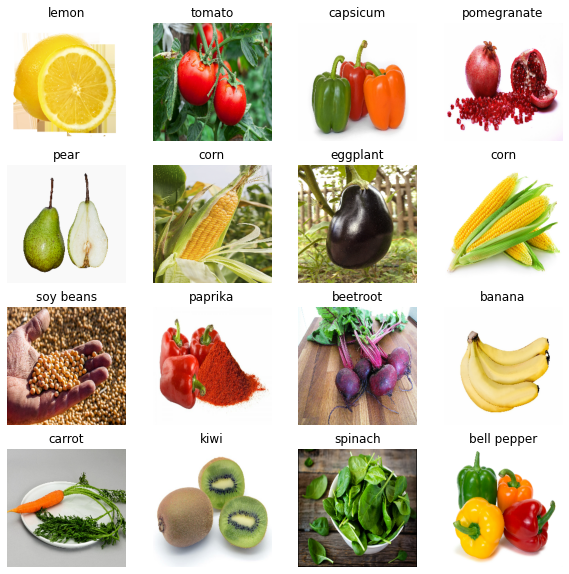

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [35]:
base_model.trainable = False

In [36]:
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [37]:
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

In [38]:
model = tf.keras.Model(inputs=inputs, outputs=x, name="flower_vegetable_Detection_MobileNetV2")

In [40]:
# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ["accuracy"])

In [41]:
model.summary()

Model: "flower_vegetable_Detection_MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)          

In [42]:
initial_epochs = 5

In [43]:
# Fit the model
history = model.fit(x=train_ds,
                    epochs= initial_epochs,
                    validation_data=valid_ds)

Epoch 1/5


12/12 [==============================] - 46s 3s/step - loss: 2.9697 - accuracy: 0.2591 - val_loss: 1.1635 - val_accuracy: 0.7939
Epoch 2/5
12/12 [==============================] - 34s 3s/step - loss: 0.9125 - accuracy: 0.7242 - val_loss: 0.4182 - val_accuracy: 0.8802
Epoch 3/5
12/12 [==============================] - 38s 3s/step - loss: 0.3958 - accuracy: 0.8524 - val_loss: 0.2585 - val_accuracy: 0.9248
Epoch 4/5
12/12 [==============================] - 41s 3s/step - loss: 0.2650 - accuracy: 0.9220 - val_loss: 0.2137 - val_accuracy: 0.9304
Epoch 5/5
12/12 [==============================] - 34s 3s/step - loss: 0.2299 - accuracy: 0.9136 - val_loss: 0.1305 - val_accuracy: 0.9610


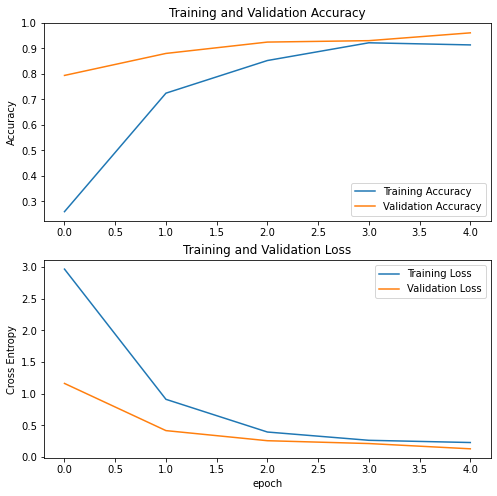

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
base_model.trainable = True

In [46]:
# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(1e-5),
    metrics = ["accuracy"])

In [48]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 5/10


12/12 [==============================] - 104s 6s/step - loss: 0.1045 - accuracy: 0.9582 - val_loss: 0.1013 - val_accuracy: 0.9749
Epoch 6/10
12/12 [==============================] - 70s 5s/step - loss: 0.0918 - accuracy: 0.9721 - val_loss: 0.0792 - val_accuracy: 0.9749
Epoch 7/10
12/12 [==============================] - 69s 5s/step - loss: 0.0479 - accuracy: 0.9833 - val_loss: 0.0713 - val_accuracy: 0.9749
Epoch 8/10
12/12 [==============================] - 72s 6s/step - loss: 0.0463 - accuracy: 0.9861 - val_loss: 0.0629 - val_accuracy: 0.9749
Epoch 9/10
12/12 [==============================] - 69s 5s/step - loss: 0.0549 - accuracy: 0.9805 - val_loss: 0.0561 - val_accuracy: 0.9749
Epoch 10/10
12/12 [==============================] - 70s 5s/step - loss: 0.0417 - accuracy: 0.9889 - val_loss: 0.0657 - val_accuracy: 0.9777


In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

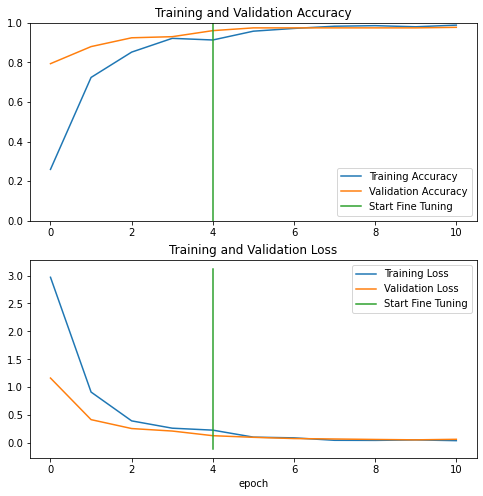

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
# Make prediction on the validation data (not used to train on)
predictions = model.predict(valid_ds, verbose=1)

12/12 [==============================] - 16s 1s/step


In [52]:
predictions.shape

(359, 36)

In [53]:
np.sum(predictions[0])

1.0

In [54]:
predictions[0]

array([9.9925035e-01, 4.1131855e-07, 1.6459523e-04, 1.0097069e-08,
       8.5186072e-09, 7.4090032e-09, 4.5920725e-08, 1.8317813e-06,
       4.8308597e-09, 9.2928694e-08, 1.8061583e-10, 8.7942902e-07,
       5.3521925e-09, 1.1054490e-08, 2.6915239e-07, 3.1593330e-09,
       1.5767294e-07, 4.6503405e-07, 1.5640131e-09, 5.5518190e-05,
       2.3605358e-05, 1.8788823e-07, 6.6741569e-07, 2.8972615e-06,
       2.0945421e-09, 1.8091493e-08, 2.3106740e-04, 4.4352983e-06,
       7.9971387e-06, 2.6478363e-08, 2.4621294e-09, 4.7766939e-08,
       8.4162366e-06, 2.0715139e-04, 5.3950948e-06, 3.3435117e-05],
      dtype=float32)

In [55]:
class_names[np.argmax(predictions[0])]

'apple'

In [56]:
class_names[np.argmax(predictions[0])]

'apple'

In [57]:
score = tf.nn.softmax(predictions[0])
score

<tf.Tensor: shape=(36,), dtype=float32, numpy=
array([0.07201647, 0.02651326, 0.02651761, 0.02651325, 0.02651325,
       0.02651325, 0.02651325, 0.0265133 , 0.02651325, 0.02651325,
       0.02651325, 0.02651327, 0.02651325, 0.02651325, 0.02651325,
       0.02651325, 0.02651325, 0.02651326, 0.02651325, 0.02651472,
       0.02651387, 0.02651325, 0.02651327, 0.02651333, 0.02651325,
       0.02651325, 0.02651937, 0.02651336, 0.02651346, 0.02651325,
       0.02651325, 0.02651325, 0.02651347, 0.02651874, 0.02651339,
       0.02651413], dtype=float32)>

In [58]:
np.save('class_names.npy',class_names)

In [59]:
model.save("flower_vegetable_detection_mobilenetv2.h5")

In [60]:
model.evaluate(test_ds)

12/12 [==============================] - 14s 1s/step - loss: 0.0657 - accuracy: 0.9777


[0.06573500484228134, 0.9777158498764038]

In [63]:
 model = tf.keras.models.load_model('flower_vegetable_detection_mobilenetv2.h5')

In [64]:
import pickle

# assume your recognition model is stored in a variable called `model`
# and you want to save it to a file called `model.pkl`
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\flatten
......vars
...layers\functional
......vars
...layers\functional\layers\add
......vars
...layers\functional\layers\add_1
......vars
...layers\functional\layers\add_2
......vars
...layers\functional\layers\add_3
......vars
...layers\functional\layers\add_4
......vars
...layers\functional\layers\add_5
......vars
...layers\functional\layers\add_6
......vars
...layers\functional\layers\add_7
......vars
...layers\functional\layers\add_8
......vars
...layers\functional\layers\add_9
......vars
...layers\functional\layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\functional\layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\functional\layers\batch_normalization_10
......vars
....